# Effects of Framing Styles in Physical Activity Intervention
## Thalia Viranda, Katara Zhiduo Xie, Melissa Tan


This document contains our data cleaning and preprocessing steps. 


/var/folders/d4/r8r1yf_553vdy3s6c02sl1z00000gn/T/ipykernel_39583/1305670723.py:31: DtypeWarning: Columns (21,22,38,39,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))
/opt/anaconda3/envs/ml_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


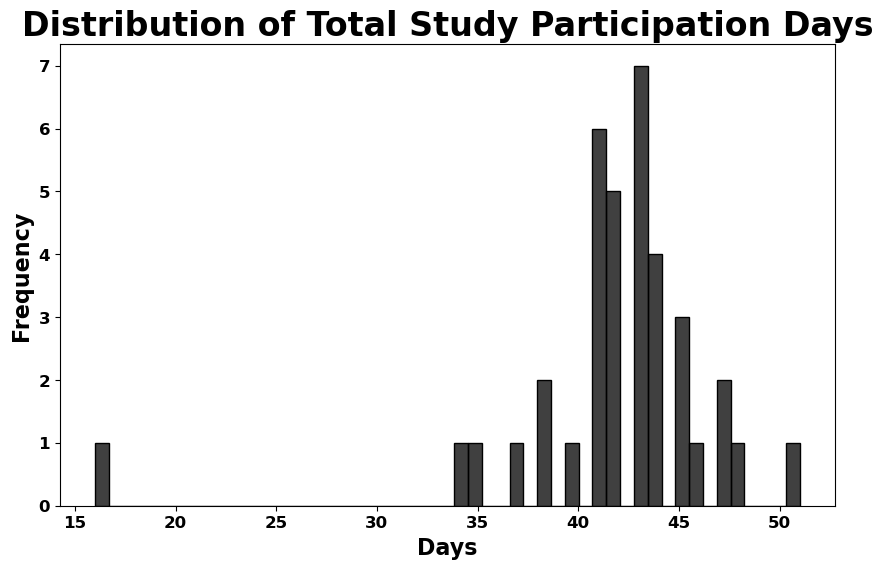

count    197524.000000
mean         27.155085
std          88.415296
min           1.000000
25%           1.000000
50%           4.000000
75%          27.000000
max        4929.000000
Name: steps, dtype: float64
Unique users in clean_steps_notif_users: 35
Unique users in mydata_steps_gf: 35


In [44]:
import os
import importlib
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set working directory - CHANGE THIS TO YOUR PATH
main_dir = "/Users/thaliaviranda/Documents/GitHub/ORIE-5160-midterm-project/"
data_dir = os.path.join(main_dir, "data/")
os.chdir(main_dir)  # Change the current working directory

# Load packages
# Define a list of package names
packages = ["pandas", "numpy", "matplotlib", "seaborn", "statsmodels"]

# Function to install and import packages
for pkg in packages:
    try:
        importlib.import_module(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        globals()[pkg] = importlib.import_module(pkg)

# Read CSV files
steps_gf = pd.read_csv(os.path.join(data_dir, "gfsteps.csv"))
steps_jb = pd.read_csv(os.path.join(data_dir, "jbsteps.csv"))
users_info = pd.read_csv(os.path.join(data_dir, "users.csv"))
suggestions_dat = pd.read_csv(os.path.join(data_dir, "suggestions.csv"))


# Assuming `users_info` DataFrame is already loaded
# Select specific columns
mydata_qs = users_info.filter(regex="user.index|totaldays|^selfeff")


# Reverse Scoring and Summed Variables
mydata_qs = mydata_qs.assign(
    selfeff_badmood_intake_r = 6 - mydata_qs["selfeff.badmood.intake"],
    selfeff_notime_intake_r = 6 - mydata_qs["selfeff.notime.intake"],
    selfeff_tired_intake_r = 6 - mydata_qs["selfeff.tired.intake"],
    selfeff_vaca_intake_r = 6 - mydata_qs["selfeff.vaca.intake"],
    selfeff_precip_intake_r = 6 - mydata_qs["selfeff.precip.intake"],
    
    # Summing intake reverse-scored values
    selfeff_intake_r = lambda x: (
        x["selfeff_notime_intake_r"] + x["selfeff_tired_intake_r"] +
        x["selfeff_vaca_intake_r"] + x["selfeff_precip_intake_r"] +
        x["selfeff_badmood_intake_r"]
    ),

    selfeff_badmood_exit_r = 6 - mydata_qs["selfeff.badmood.exit"],
    selfeff_notime_exit_r = 6 - mydata_qs["selfeff.notime.exit"],
    selfeff_tired_exit_r = 6 - mydata_qs["selfeff.tired.exit"],
    selfeff_vaca_exit_r = 6 - mydata_qs["selfeff.vaca.exit"],
    selfeff_precip_exit_r = 6 - mydata_qs["selfeff.precip.exit"],

    # Summing exit reverse-scored values
    selfeff_exit_r = lambda x: (
        x["selfeff_notime_exit_r"] + x["selfeff_tired_exit_r"] +
        x["selfeff_vaca_exit_r"] + x["selfeff_precip_exit_r"] +
        x["selfeff_badmood_exit_r"]
    )
)


# Histogram of Total Days
plt.figure(figsize=(10, 6))
sns.histplot(mydata_qs['totaldays'], bins=51, color="black", edgecolor="black")
plt.title("Distribution of Total Study Participation Days", fontsize=24, fontweight="bold")
plt.xlabel("Days", fontsize=16, fontweight="bold")
plt.ylabel("Frequency", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
# plt.gca().set_facecolor("transparent")
plt.savefig("hist_totalday.png", transparent=True)
plt.show()

# Creating Notification Type Data
notif_type = suggestions_dat[['user.index', 'decision.index', 'send', 'send.active', 'send.sedentary']]

# Merging Data
steps_notif = pd.merge(steps_gf, notif_type, on=['user.index', 'decision.index'], how='outer')
steps_notif_users = pd.merge(steps_notif, mydata_qs, on='user.index', how='outer')

# Converting columns to boolean
steps_notif_users['send'] = steps_notif_users['send'].astype(bool)
steps_notif_users['send.active'] = steps_notif_users['send.active'].astype(bool)

# Sorting and modifying user.index
steps_notif_users = steps_notif_users.sort_values(by='steps.utime')
steps_notif_users['user.index'] = pd.to_numeric(steps_notif_users['user.index'], errors='coerce')

# Summary Statistics
steps_summary = steps_notif_users['steps'].describe()
print(steps_summary)

# Exporting Data to CSV
steps_notif_users.to_csv(os.path.join(data_dir, "steps_notif_users_py.csv"), index=False)



# # Function to handle missing data in 'steps' column using LOCF
# def handle_missing_steps_locf(data):
#     data['steps'] = data['steps'].fillna(method='ffill')
#     return data

# # Apply LOCF to steps column
# steps_notif_users = handle_missing_steps_locf(steps_notif_users)

# Filter and transform steps_notif_users
clean_steps_notif_users = (
    steps_notif_users
    .loc[(steps_notif_users['send'] == True) & (~steps_notif_users['user.index'].isin([29, 22])) & (~steps_notif_users['decision.index'].isna())]  # Filtering for send == True and excluding users 29 and 22 and those with missing decision index
    .assign(
        notif_type=lambda x: x['send.active'].apply(lambda y: "Active" if y else "Sedentary"),
        steps_date=lambda x: pd.to_datetime(x['steps.utime']).dt.date
    )
    .dropna(subset=['notif_type'])  # Ensure notif_type is not NA
    .sort_values(by=['user.index', 'steps.utime'])
    .assign(
        day=lambda x: x.groupby('user.index')['steps_date'].transform(lambda y: pd.factorize(y)[0] + 1)
    )
)


# Summary statistics, filtering, and transformations for mydata_steps_gf
mydata_steps_gf = (
    clean_steps_notif_users
    .loc[:, ['user.index', 'steps_date', 'day', 'notif_type', 'decision.index', 'steps', 'selfeff_intake_r']]
    .groupby(['user.index', 'day', 'notif_type', 'decision.index', 'selfeff_intake_r'], as_index=False)
    .agg(
        n=('steps', 'size'),
        total_steps=('steps', 'sum')
    )
    .dropna(subset=['total_steps'])  # Filter rows where total_steps is NA
    .sort_values(by=['user.index', 'decision.index']
))

# View the count of unique users in clean_steps_notif_users and mydata_steps_gf
unique_user_count_clean = clean_steps_notif_users['user.index'].nunique()
unique_user_count_mydata = mydata_steps_gf['user.index'].nunique()

print(f"Unique users in clean_steps_notif_users: {unique_user_count_clean}")
print(f"Unique users in mydata_steps_gf: {unique_user_count_mydata}")

# Exporting Data to CSV
mydata_steps_gf.to_csv(os.path.join(data_dir, "mydata_steps_gf_py.csv"), index=False)

